# **FLOW ACCUMULATION**

## Načtení potřebných knihoven

**Tato část kódu načítá potřebné knihovny pro vytvoření skriptu na výpočet FLOW ACCUMULATION. Zde je stručný popis každé z použitých knihoven:**

- `numpy`: pro práci s numerickými daty a vektorovými operacemi
- `pysheds.grid`: pro manipulaci s digitálním modelem terénu (DEM) a hydrologickými analýzami
- `matplotlib.pyplot`: pro vizualizaci dat a grafický výstup
- `matplotlib.colors`: pro práci s barvami
- `matplotlib.patches`: pro vytváření grafických prvků
- `seaborn`: pro statistickou vizualizaci dat, rozšíření nad matplotlib
- `rasterio`: pro práci s rastry a jejich čtení/zápis

In [19]:
# Načtení potřebných knihoven
import numpy as np
from pysheds.grid import Grid
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns
import rasterio

## Načtení digitálního modelu terénu (DEM)

**Tato část kódu načítá digitální model terénu (DEM) z dané cesty.** 

- Proměnná `dem_file` obsahuje cestu k souboru DEM.
- Proměnná `grid` vytváří objekt Grid z knihovny `pysheds`, který bude použit pro manipulaci s daty DEM. 
- Proměnná `dem` obsahuje samotná data DEM načtená z souboru pomocí objektu `grid`.

In [18]:
# Vložení relativní cesty k souboru
path='data/dem3.tif'

# Načtení digitálního modelu terénu (DEM) z přiložené cesty
grid = Grid.from_raster(path)
dem = grid.read_raster(path)
dem_file = path

## Vytvoření náhledu digitálního modelu terénu (DEM)

**Tato část kódu vytváří vizuální náhled digitálního modelu terénu. Graf zobrazuje nadmořské výšky různých oblastí.**

- Graf má definovanou velikost a průhledné pozadí, což zajišťuje jeho lepší čitelnost.
- Barevné schéma 'terrain' se používá pro zobrazení různých výškových úrovní. Tímto způsobem lze snadno rozlišit různé nadmořské výšky.
- Legenda je přidána k grafu, aby uživatel mohl snadno určit hodnoty nadmořské výšky zobrazené na grafu.

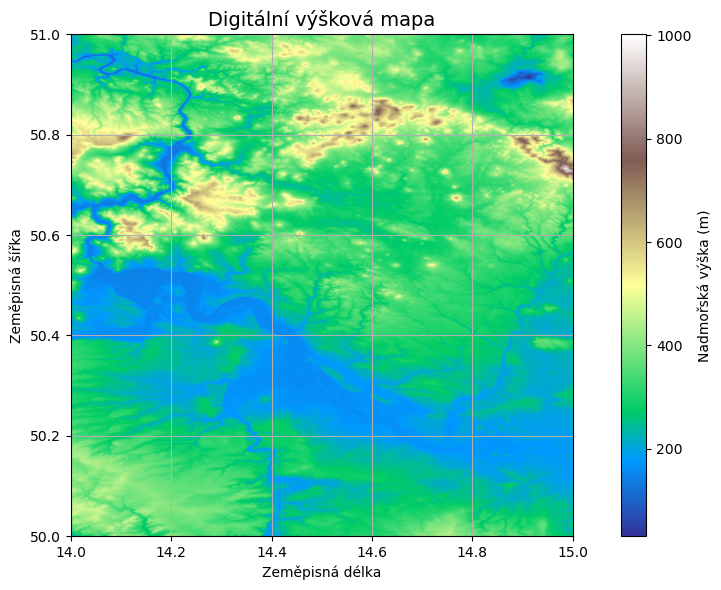

In [7]:
# Vytvoření náhledu a osy grafu a průhlednosti
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_alpha(0)

# Zobrazení DEM s použitím barevného schématu 'terrain'
plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)

# Přidání legendy
plt.colorbar(label='Nadmořská výška (m)')

# Přidání mřížky
plt.grid(zorder=0)

# Popisky
plt.title('Digitální výšková mapa', size=14)
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.tight_layout()

## Úpravy v digitálním modelu terénu (DEM)

**Tato část kódu provádí několik úprav v digitálním modelu terénu (DEM) za účelem zajištění jeho přesnosti a konzistence:**

- **Vyplnění propadlin**: Funkce `grid.fill_pits()` vyplňuje propadliny v digitálním modelu terénu (DEM). Propadliny jsou oblasti, kde voda stéká do jednoho bodu, což může způsobit problémy při analýze hydrologických dat.

- **Vyplnění depresí**: Funkce `grid.fill_depressions()` vyplňuje depresní oblasti v digitálním modelu terénu (DEM). Deprese jsou oblasti, ve kterých voda nemá odvodňování do okolních oblastí, což může vést k nekonzistentním výsledkům při analýze toku vody.

- **Oprava plochých oblastí**: Funkce `grid.resolve_flats()` provádí opravy plochých oblastí v digitálním modelu terénu (DEM). Ploché oblasti jsou místa, kde voda nemá jednoznačný směr toku, což může vést k nesprávným výsledkům při analýze toku vody. Oprava těchto oblastí zajistí, že tok vody bude správně modelován a analyzován.

In [8]:
# Vyplnění propadlin v digitálním modelu terénu
pit_filled_dem = grid.fill_pits(dem)

# Vyplnění depresí
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Oprava plochých oblastí v digitálním modelu terénu
inflated_dem = grid.resolve_flats(flooded_dem)

## Definice směrů toku (flow directions)

**V této části kódu jsou definovány směry toku, které budou použity pro výpočet toku vody v digitálním modelu terénu. Směry toku jsou určeny pomocí číselných hodnot, které odpovídají osmi světovým stranám.**

- Proměnná `dirmap` obsahuje seznam osmi číselných hodnot, které reprezentují směry toku. Čísla jsou vyjádřena jako mocniny čísla 2, což umožňuje snadné porovnání směrů toku pomocí binární reprezentace.

- Výpočet směrů toku je proveden pomocí metody `grid.flowdir()`, která přiřazuje každé buňce v digitálním modelu terénu (DEM) směr toku vody na základě topografie terénu a definovaných směrů. Tímto způsobem je vytvořen nový objekt `fdir`, který obsahuje informace o směrech toku v celém digitálním modelu terénu.

In [9]:
# Definice směrů toku (flow directions)
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Výpočet směrů toku na vyplněném DEM
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

## Vykreslení sítě směrů toku

**V této části kódu je zobrazena síť směrů toku, která byla vypočtena na základě digitálního modelu terénu.**

- První část kódu vytváří graf s definovanou velikostí pomocí `plt.figure(figsize=(10,6))`. Průhlednost pozadí je nastavena na 0 pomocí `fig.patch.set_alpha(0)`, což zajišťuje, že pozadí grafu bude průhledné.
- Samotná síť směrů toku je zobrazena pomocí `plt.imshow()`. Barevné schéma 'viridis' je použito k vizualizaci různých směrů toku.
- Legenda zobrazuje různé směry toku na základě definovaných hodnot v `dirmap`.
- Popisky os a titulek grafu jsou nastaveny pro lepší orientaci.
- Mřížka je zobrazena pod daty sítě směrů toku, což pomáhá s orientací na grafu.

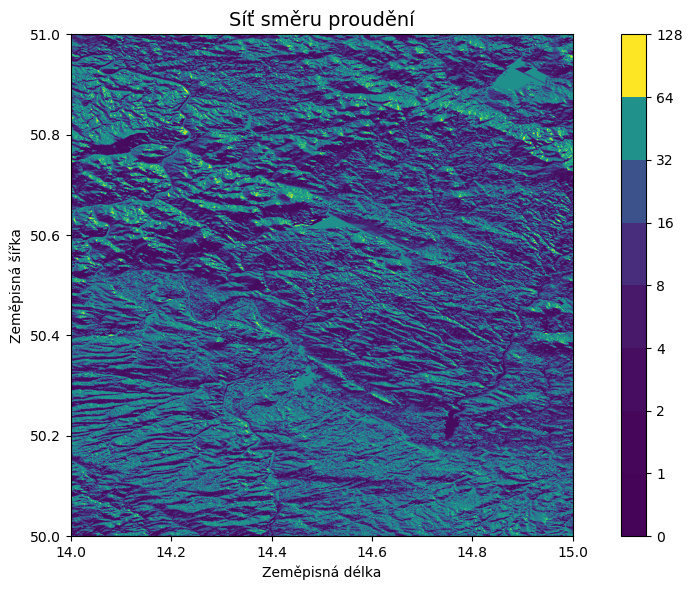

In [10]:
# Vymezení plátna a nastavení průhlednosti
fig = plt.figure(figsize=(10,6))
fig.patch.set_alpha(0)

# Zobrazení směrů toku
plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)

# Legenda
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries=boundaries, values=sorted(dirmap))

# Popisky
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.title('Síť směru proudění', size=14)
plt.grid(zorder=-1)
plt.tight_layout()


## Výpočet akumulace toku

**V této části kódu je proveden výpočet akumulace toku na základě směrů toku v digitálním modelu terénu (DEM).**

- Funkce `grid.accumulation()` vypočítává akumulaci toku na základě směrů toku definovaných v `fdir`. Tato akumulace toku určuje, kolik vody se nakonec dostane do každé buňky v digitálním modelu terénu na základě topografie terénu a směrů toku vody. 
- Argument `dirmap` je použit pro definici směrů toku, které jsou použity při výpočtu akumulace toku. Tento argument zajišťuje konzistenci mezi směry toku použitými při výpočtu směrů toku a akumulaci toku.

In [11]:
# Výpočet akumulace toku na základě směrů toku
acc = grid.accumulation(fdir, dirmap=dirmap)

## Vizualizace akumulace toku

**V této části kódu je vizualizována akumulace toku na základě vypočtených směrů toku.**

- První část kódu vytváří graf s definovanou velikostí pomocí `plt.subplots(figsize=(8,6))`. Průhlednost pozadí je nastavena na 0 pomocí `fig.patch.set_alpha(0)`, což zajišťuje, že pozadí grafu bude průhledné.
- Mřížka je přidána na pozadí grafu pomocí `plt.grid('on', zorder=0)`, což pomáhá s orientací na grafu.
- Akumulace toku je zobrazena pomocí `ax.imshow()`. Barevné schéma 'cubehelix' je použito k vizualizaci různých úrovní akumulace toku.
- Legenda je přidána pomocí `plt.colorbar()` s popiskem 'Buňky na horním toku', což umožňuje uživateli snadno interpretovat hodnoty akumulace toku.
- Popisky os a titulek grafu jsou nastaveny pro lepší orientaci.

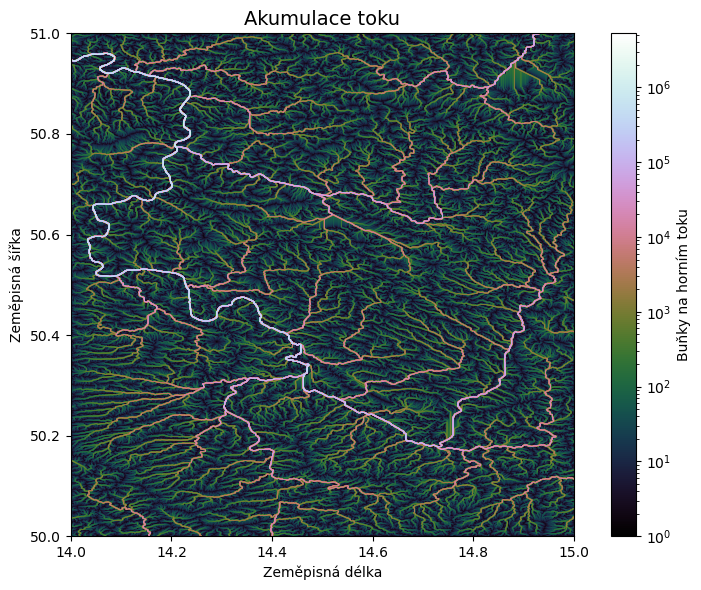

In [12]:
# Nastavení plátna a průhlednosti
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

# Přidání mřížky s pozadím
plt.grid('on', zorder=0)

# Zobrazení akumulace toku
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')

# Legenda + popis
plt.colorbar(im, ax=ax, label='Buňky na horním toku')

# Popisky
plt.title('Akumulace toku', size=14)
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.tight_layout()

## Zjištění nejnižšího bodu v digitálním modelu terénu

**V této části kódu je provedena práce nad digitálním modelem pro získání souřadnic nejnižšího bodu v rastru**

- Soubor DEM je otevřen pomocí funkce `rasterio.open(dem_file)`. 
- Data DEM jsou načtena ze souboru pomocí `src.read(1)` a uložena do proměnné `dem_data`.
- Nejnižší hodnota nadmořské výšky v digitálním modelu terénu je získána pomocí `dem_data.min()` a uložena do proměnné `min_elevation`.
- Index nejnižší hodnoty nadmořské výšky je získán pomocí `dem_data.argmin()` a uložen do proměnné `min_index`.
- Zeměpisné souřadnice odpovídající minimální hodnotě nadmořské výšky jsou získány pomocí `src.xy(min_index[0], min_index[1])` a uloženy do proměnných `x_min` a `y_min`.

In [14]:
# Otevření DEM souboru
with rasterio.open(dem_file) as src:
    # Načtení dat DEM
    dem_data = src.read(1)
    
    # Zjištění minimální hodnoty nadmořské výšky
    min_elevation = dem_data.min()

'''print("Minimální hodnota nadmořské výšky v DEM:", min_elevation)'''

# Zjištění indexu minimální hodnoty nadmořské výšky
min_index = np.unravel_index(dem_data.argmin(), dem_data.shape)

# Převod indexu na zeměpisné souřadnice
x_min, y_min = src.xy(min_index[0], min_index[1])

## Vytvoření povodí pro zvolený bod

- Pro vybraný bod, který je definován jako nejnižší bod v rastru, jsou určeny nejbližší body na povrchu s akumulací toku nad 1000 buňek pomocí funkce `grid.snap_to_mask()`. Tyto body jsou uloženy do proměnných `x_snap` a `y_snap`.
- Povodí je vytvořeno pro zvolený bod (určený pomocí `x_snap` a `y_snap`) pomocí funkce `grid.catchment()`. Tato funkce vytváří povodí na základě směrů toku v daném digitálním modelu terénu (DEM).
- Mřížka je oříznuta na rozsah povodí pomocí funkce `grid.clip_to()`, což zajišťuje, že grafické zobrazení bude obsahovat pouze oblast povodí.

In [15]:
# Zvolení souřadnic nejnižšího bodu v rastru
x_min, y_min

# Určení nejbližšího bodu na povrchu s akumulací toku nad 1000 buňek
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x_min, y_min))

# Vytvoření povodí pro zvolený bod (x_snap, y_snap)
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Oříznutí mřížky na rozsah povodí
grid.clip_to(catch)

# Zobrazení oříznutého povodí
clipped_catch = grid.view(catch)

## Extrahování říční sítě

**V této části kódu je provedena extrakce říční sítě na základě směrů a akumulace toku.**

- Funkce `grid.extract_river_network()` extrahuje říční sítě na základě směrů toku v `fdir` a podmínky, že akumulace toku musí být vyšší než 50. Tímto způsobem jsou identifikovány říční sítě na základě topografie terénu a množství vody ve směrech toku.
- Výsledek extrakce říční sítě je uložen do proměnné `branches`. Tato proměnná obsahuje informace o jednotlivých větvích říční sítě, včetně souřadnic a geometrie každé větve.

In [16]:
# Extrahování říční sítě
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

## Vizualizace směrů toku

**V této části kódu jsou zobrazeny směry toku v digitálním modelu terénu (DEM) spolu s legendou popisků směrů.**

- Nejprve jsou definovány popisky směrů toku pomocí seznamu `dirmap_labels`, který obsahuje textové popisky pro jednotlivé směry.
- Barevná paleta je nastavena pomocí knihovny Seaborn na základě palety 'husl'.
- Graf je vytvořen s pomocí funkce `plt.subplots(figsize=(8.5,6.5))`, kde jsou nastaveny velikosti osy X a Y na základě rozsahu mřížky digitálního modelu terénu (DEM).
- Vykreslení jednotlivých větví říční sítě je provedeno pomocí iterace přes všechny větve v proměnné `branches['features']`.
- Legenda je vytvořena ručně pomocí barev z palety 'husl' a popisků směrů z proměnné `dirmap_labels`. Legenda je přidána do grafu v pravém horním rohu s pomocí `plt.legend()`.

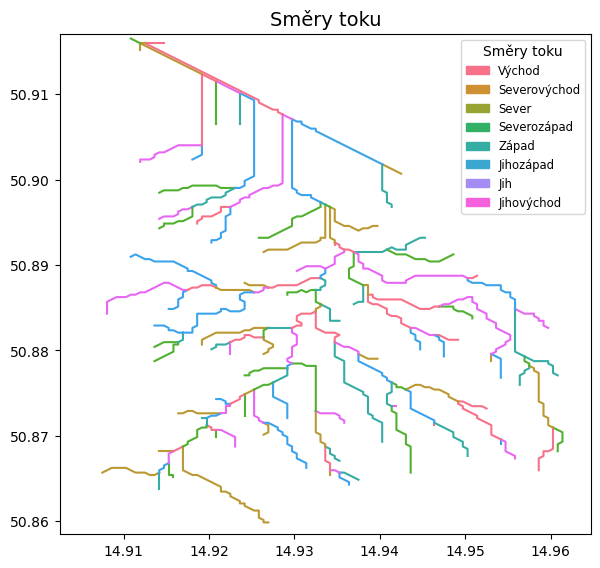

In [17]:
# Definice seznamu popisků směrů toku
dirmap_labels = ['Východ', 'Severovýchod', 'Sever', 'Severozápad', 'Západ', 'Jihozápad', 'Jih', 'Jihovýchod']

# Nastavení barev palety pomocí knihovny Seaborn
sns.set_palette('husl')

# Vytvoření mapy a os
fig, ax = plt.subplots(figsize=(8.5,6.5))
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])

# Nastavení stejného měřítka na obě osy pro zachování poměru stran
ax.set_aspect('equal')

# Iterace přes jednotlivé větve říční sítě
for branch in branches['features']:
    # Extrahování souřadnic linie větve
    line = np.asarray(branch['geometry']['coordinates'])
    # Vykreslení linie
    plt.plot(line[:, 0], line[:, 1])

# Nastavení titulku grafu
_ = plt.title('Směry toku', size=14)

# Seznam barev z palety husl
colors = sns.color_palette('husl', len(dirmap_labels))

# Ruční vytvoření legendy
legend_handles = [mpatches.Patch(color=colors[i], label=dirmap_labels[i]) for i in range(len(dirmap_labels))]

# Přidání legendy do grafu s umístěním v pravém horním rohu
plt.legend(handles=legend_handles, title='Směry toku', loc='upper right', fontsize='small')

## Výpočet vzdálenosti od ústí do každé buňky

**V této části kódu je proveden výpočet vzdálenosti od ústí do každé buňky v digitálním modelu terénu.**

- Funkce `grid.distance_to_outlet()` vypočítává vzdálenost od ústí do každé buňky na základě zadaných parametrů:
  - `x` a `y`: souřadnice bodu na povrchu, který slouží jako ústí
  - `fdir`: směry toku v digitálním modelu terénu (DEM)
  - `dirmap`: mapa směrů
  - `xytype='coordinate'`: specifikace, že souřadnice bodu jsou v zeměpisném formátu.

- Výsledná vzdálenost od ústí do každé buňky je uložena do proměnné `dist`.

In [ ]:
# Výpočet vzdálenosti od ústí do každé buňky
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

## Vizualizace vzdálenosti toku

**V této části kódu je provedena vizualizace vzdálenosti od ústí do každé buňky v digitálním modelu terénu**

- Nejprve je vytvořena instance obrázku a osy s pomocí funkce `plt.subplots(figsize=(10,6))`. Průhlednost obrázku je nastavena na nulu.
- Mřížka je přidána pomocí `plt.grid('on', zorder=0)` pro lepší orientaci.
- Vykreslení vzdálenosti je provedeno pomocí `ax.imshow()`, kde je použit colormap 'cubehelix_r' pro zobrazení barevného schématu. Zde `dist` obsahuje vzdálenosti od ústí do každé buňky.
- Barevná škála je přidána pomocí `plt.colorbar()` s popiskem 'Vzdálenost k odtoku (buňky)'.
- Popisky os X a Y jsou nastaveny na 'Zeměpisná délka' a 'Zeměpisná šířka' a titul je nastaven na 'Vzdálenost toku'.

In [ ]:
# Vytvoření vizualizace
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)

# Vykreslení vzdálenosti od ústí do každé buňky na základě DEM
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')

# PLegenda a popisky
plt.colorbar(im, ax=ax, label='Vzdálenost k odtoku (buňky)')
plt.xlabel('Zeměpisná délka')
plt.ylabel('Zeměpisná šířka')
plt.title('Vzdálenost toku', size=14)